### Author: Frederick Tan
### Student ID: 16227617
### Assignment Number: 3

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as py
import tabulate
from pylab import rcParams
from IPython.display import HTML, display

%matplotlib inline
matplotlib.style.use('ggplot')

# Introduction

The problem requirement is to "write a parallel program, that runs on a multi-core workstation, to solve for the distribution of temperatures across a printed circuit plate. The plate is initialized with a number of components and wires of fixed temperatures. This can be done using the finite difference method whereby one iteratively finds a solution to Laplace’s equation."

The assignment requirement is to write a GPU implementation of the algorithm to derive the source image positions.

# System Configuration

The workstation used for this exercise is a 64-bit HP Z-420 machine with the specification given by the table below.

In [2]:
table = [['Number of Processors', '8'],
         ['Number of Cores per Processor', '4'],
         ['Number of Threads per Core', '2']]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

With the specification above, the maximum number of thread that can be used for the test is 64. The test is then designed to test the speedup versus number of threads and the size of the image. To remove the hard disk size limitation, the output is not saved.

```
for size in {50..10000..50}; do
    ./heat ${size} >> ${result_dir}/result.base
    for nth in {1..64..1}; do
        ./heat_omp ${size} ${nth} >> ${result_dir}/result.parallel
    done
don
```

```For the test above, ${size} corresponds to the size of the image. ${nth} is the number of threads.```

# Code Implementation

The author created two versions of the solution. The first version is generally using static scheduling in the main for loops. The second is using dynamic scheduling, along with reduction.

While doing the research, the author learned that, although theoretically a dynamic scheduling model will perform better, there are instances where it is the opposite as there is an additional overhead for the assignment of data (chunks).

# Processing the Data

There are two results, namely, "result.base" and "result.parallel".

The first is the controlled data and the latter is the result for the parallel version.

In [13]:
df_parallel = pd.read_csv('./result/result.parallel', names=['NTh', 'ActNThreads', 'NPix', 'TotalTime',
                                                   'MidTime', 'InitTime', 'Iteration']).drop('ActNThreads', axis=1)
df_parallel_static = pd.read_csv('./result.static/result.parallel', names=['NTh', 'ActNThreads', 'NPix', 'TotalTime',
                                                   'MidTime', 'InitTime', 'Iteration']).drop('ActNThreads', axis=1)
df_base = pd.read_csv('./result.static/result.base', names=['NPix', 'TotalTime', 'MidTime', 'InitTime', 'Iteration'])
df_parallel = df_parallel[df_parallel.NPix <= 500].reset_index(drop = True)
df_parallel_static = df_parallel_static[df_parallel_static.NPix <= 500].reset_index(drop = True)
df_base = df_base[df_base.NPix <= 500].reset_index(drop=True)

In [4]:
df_parallel.head(5)

NTh  NPix  TotalTime   MidTime  InitTime  Iteration
0    1    50   0.007852  0.007382  0.000470        998
1    2    50   0.009182  0.008787  0.000394        998
2    3    50   0.009896  0.009219  0.000678        998
3    4    50   0.010258  0.009618  0.000640        998
4    5    50   0.010375  0.009701  0.000675        998

In [5]:
df_base.head(5)

NPix  TotalTime   MidTime  InitTime  Iteration
0    50   0.005861  0.004380  0.001481        998
1   100   0.042631  0.042051  0.000579       3711
2   150   0.195311  0.194691  0.000620       7989
3   200   0.608244  0.607530  0.000714      13543
4   250   1.388730  1.387950  0.000779      20224

## Figure 1.1: Performance Per Number of Threads (Dynamic)

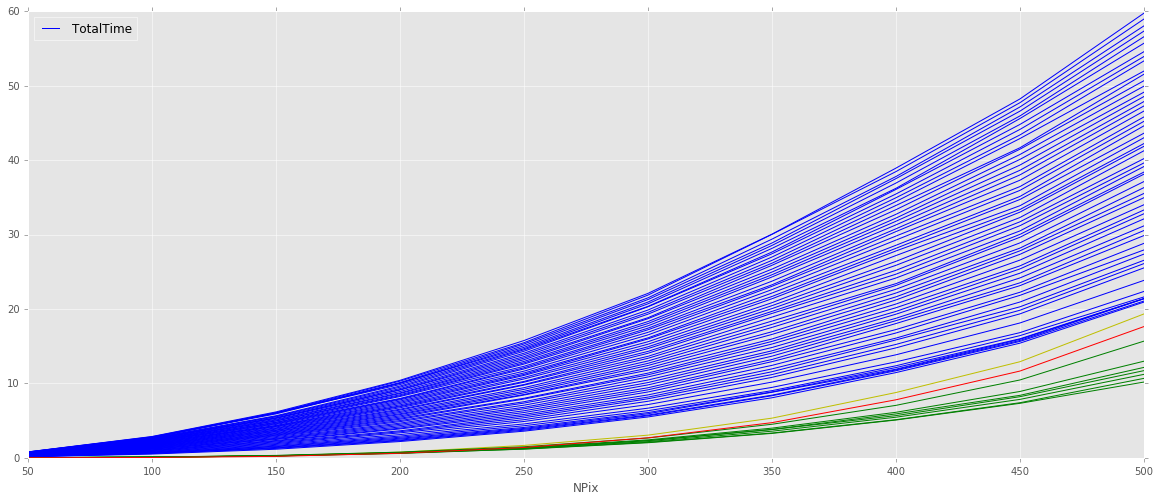

In [14]:
fig, ax = plt.subplots(figsize=(20,8))

df_parallel[df_parallel.NTh == 1].plot(x='NPix', y='TotalTime', color='y', legend=False, ax=ax)

for nth in range(2, 9):
    df_parallel[df_parallel.NTh == nth].plot(x='NPix', y='TotalTime', color='g', legend=False, ax=ax)

for nth in range(9, 64):
    df_parallel[df_parallel.NTh == nth].plot(x='NPix', y='TotalTime', color='b', legend=False, ax=ax)

df_base.plot(x='NPix', y='TotalTime', legend=False, color='r', ax=ax)

df_parallel[df_parallel.NTh == 64].plot(x='NPix', y='TotalTime', color='b', ax=ax)


## Figure 1.1: Performance Per Number of Threads (Static)

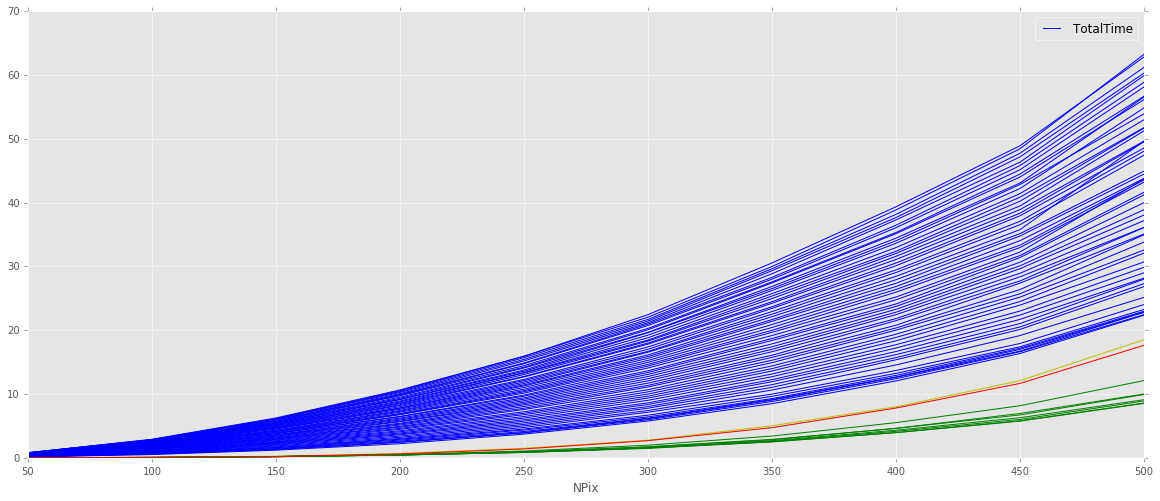

In [15]:
fig, ax = plt.subplots(figsize=(20,8))

df_parallel_static[df_parallel_static.NTh == 1].plot(x='NPix', y='TotalTime', color='y', legend=False, ax=ax)

for nth in range(2, 9):
    df_parallel_static[df_parallel_static.NTh == nth].plot(x='NPix', y='TotalTime', color='g', legend=False, ax=ax)

for nth in range(9, 64):
    df_parallel_static[df_parallel_static.NTh == nth].plot(x='NPix', y='TotalTime', color='b', legend=False, ax=ax)

df_base.plot(x='NPix', y='TotalTime', legend=False, color='r', ax=ax)

df_parallel_static[df_parallel_static.NTh == 64].plot(x='NPix', y='TotalTime', color='b', ax=ax)

The red line is the graph for the controlled test. The blue lines are the graphs for the data corresponding to thread count > 8. The yellow line corresponds to thread count = 1, which is basically similar to the controlled test. The green lines correspond to thread counts 2 to 8.

## Figure 1.2: Amhdal's Law

In [28]:
df_diff = df_parallel_static[df_parallel_static.NTh == 8].reset_index(drop=True)
df_diff['TimeImprovement'] = df_base.TotalTime - df_parallel_static.TotalTime

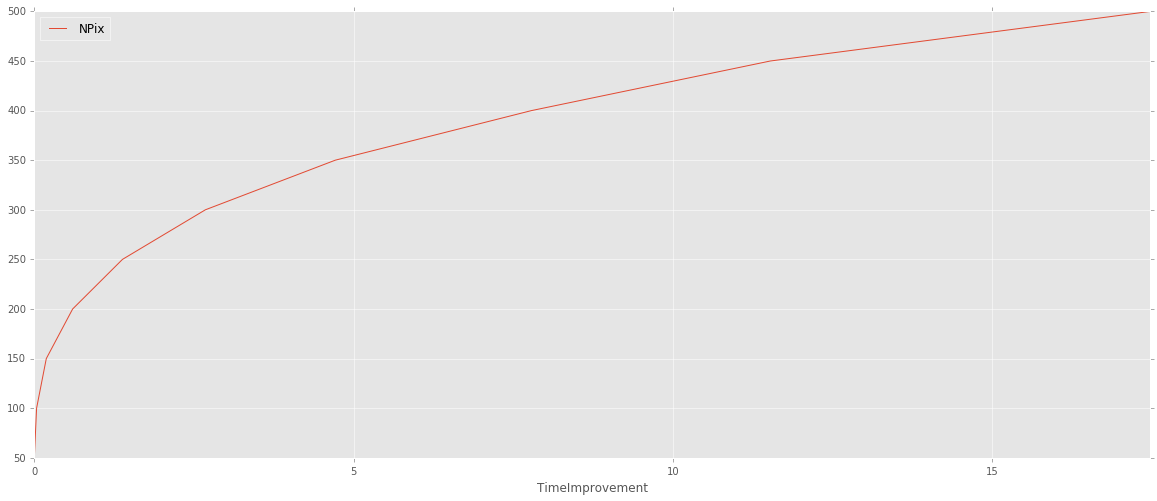

In [31]:
fig, ax = plt.subplots(figsize=(20,8))
df_diff.plot(x='TimeImprovement', y='NPix', ax=ax)

## Figure 1.3: Enlarged Performance Per Number of Threads (1 - 8)

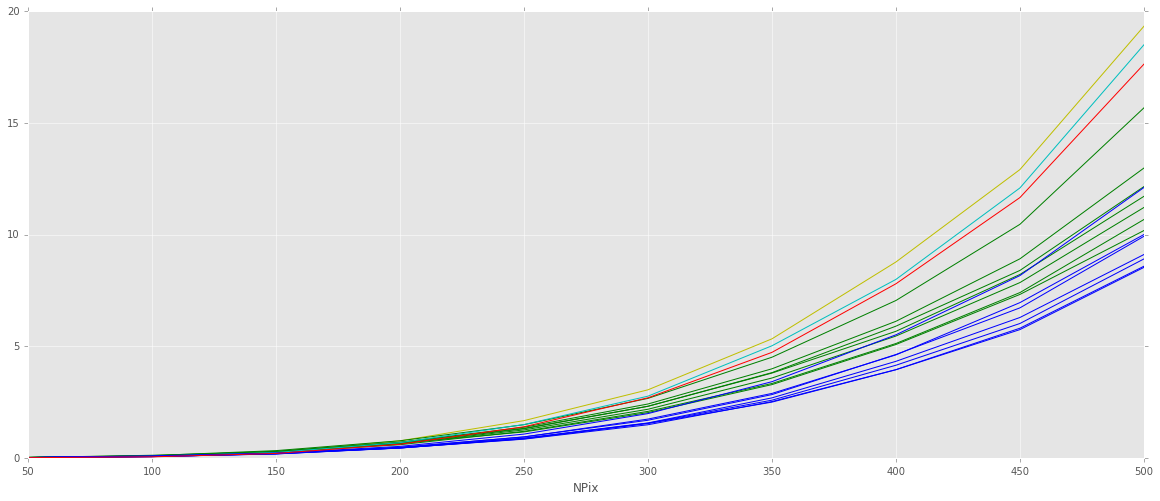

In [17]:
fig, ax = plt.subplots(figsize=(20,8))

df_parallel[df_parallel.NTh == 1].plot(x='NPix', y='TotalTime', color='y', legend=False, ax=ax)

for nth in range(2, 9):
    df_parallel[df_parallel.NTh == nth].plot(x='NPix', y='TotalTime', color='g', legend=False, ax=ax)
    
df_parallel_static[df_parallel_static.NTh == 1].plot(x='NPix', y='TotalTime', color='c', legend=False, ax=ax)

for nth in range(2, 9):
    df_parallel_static[df_parallel_static.NTh == nth].plot(x='NPix', y='TotalTime', color='b', legend=False, ax=ax)

df_base.plot(x='NPix', y='TotalTime', legend=False, color='r', ax=ax)

The blue lines represent the static version of the GPU program and the green lines represent the dynamic.

## Figure 2.1: Time vs the Number of Thread

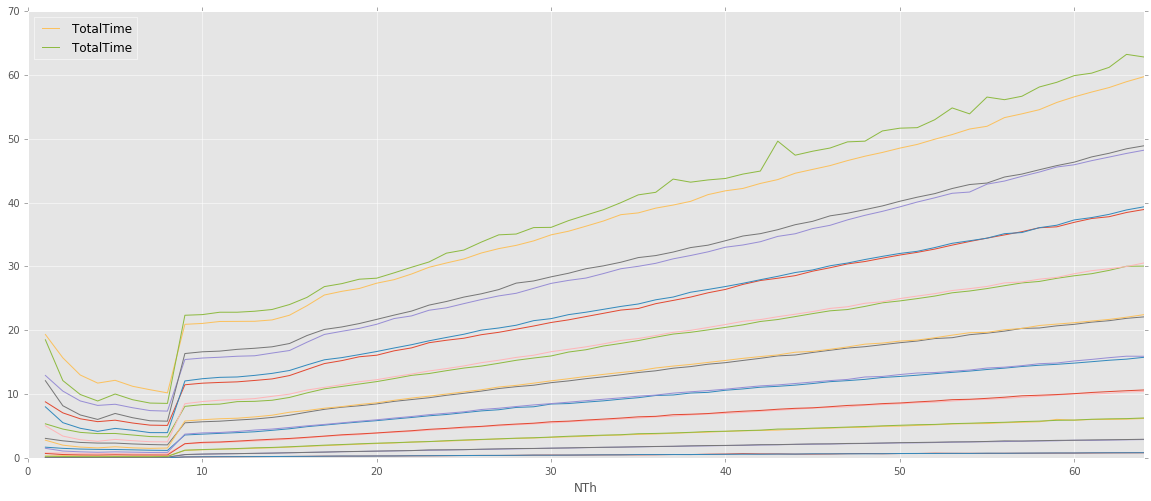

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
for npix in range(50, 500, 50):
    df_parallel[df_parallel.NPix == npix].plot(x='NTh', y='TotalTime', legend=False, ax=ax)
    df_parallel_static[df_parallel_static.NPix == npix].plot(x='NTh', y='TotalTime', legend=False, ax=ax)
    ax.axvline(label=npix)
df_parallel[df_parallel.NPix == 500].plot(x='NTh', y='TotalTime', ax=ax)
df_parallel_static[df_parallel_static.NPix == 500].plot(x='NTh', y='TotalTime', ax=ax)

# Sample Image

![title](plate1.png)

# Analysis and Conclusion

Based on the graphs, the performance boost provided for by OpenMP is limited to the first eight threads only. This most likely indicates that the first eight threads are running on the first processor. The additional threads after that are running on the other processors, incuring IPC (inter processor communication) latency penalty, and thus, the performance decline. This contradicts Gustafson’s Law.

Meanwhile, Figure 1.2 demonstrates Amhdal's Law.

This performance change is seen best on Figure 2.0. It can be noted that the time decreased from thread count 1 to thread count 8, and then started to increase again.

It is also noted that the dynamic scheduling approach has an overall better performance than the static. However, if you go down deeper on the data, you will notice that the static approach performs well when using only one processor. Please see the data below.

In [26]:
total_time_static = df_parallel_static.mean().TotalTime
total_time_one_proc_static = df_parallel_static[df_parallel_static.NTh <= 8].mean().TotalTime
total_time_more_than_one_proc_static = df_parallel_static[df_parallel_static.NTh > 8].mean().TotalTime
print('Total average time (static): ', total_time_static)
print('Total average time when using one processor (static): ', total_time_one_proc_static)
print('Total average time when using more than one processor (static): ', total_time_more_than_one_proc_static)

('Total average time (static): ', 13.893245579828113)
('Total average time when using one processor (static): ', 2.9393226511249999)
('Total average time when using more than one processor (static): ', 15.458091712499987)


In [25]:
total_time_dynamic = df_parallel.mean().TotalTime
total_time_one_proc_dynamic = df_parallel[df_parallel.NTh <= 8].mean().TotalTime
total_time_more_than_one_proc_dynamic = df_parallel[df_parallel.NTh > 8].mean().TotalTime
print('Total average time (dynamic): ', total_time_dynamic)
print('Total average time when using one processor (dynamic): ', total_time_one_proc_dynamic)
print('Total average time when using more than one processor (dynamic): ', total_time_more_than_one_proc_dynamic)

('Total average time (dynamic): ', 13.564958514375002)
('Total average time when using one processor (dynamic): ', 3.6791715024999996)
('Total average time when using more than one processor (dynamic): ', 14.977213801785719)


This is because with a limited number of threads all performing relatively fast, there are a limited number of chunks/data that can be reassigned. There are limited number of threads getting idle as they are working similarly fast. This is not the case for more threads, as the chance of other threads going idle is high, and the system can do more dynamic load balancing.